In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import random
import pickle

Using TensorFlow backend.


## Get the dataset

You can download the dataset from thie directory http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

                                            (or)
                                            
      clone from this repository "https://bitbucket.org/jadslim/german-traffic-signs"

In [2]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  valid_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
  
# print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [3]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [4]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_valid.shape[0] == y_valid.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"

assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_valid.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3"

In [5]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

## Getting a look at the dataset

Checking out all the different classes present in the dataset.

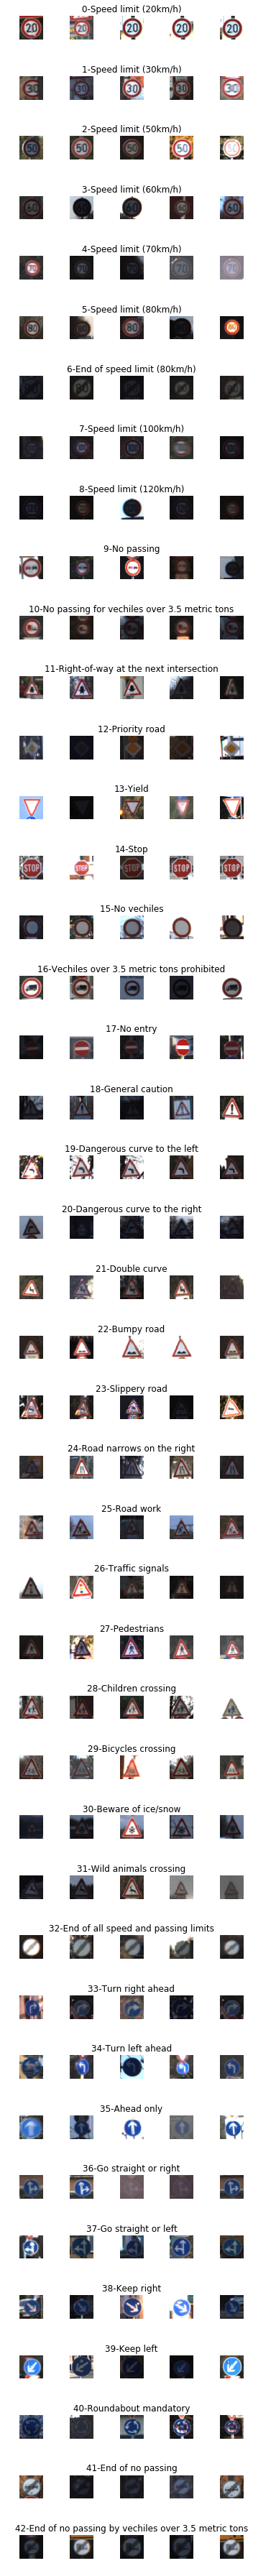

In [6]:
num_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '-' + row['SignName'])
            num_samples.append(len(x_selected))

## Distribution of the dataset, this is a imbalanced dataset, you can see the individual count of the classes.

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


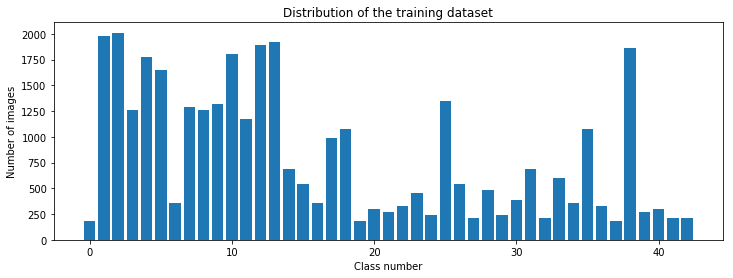

In [7]:
print(num_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

## Preprocessing the dataset

(32, 32, 3)
36


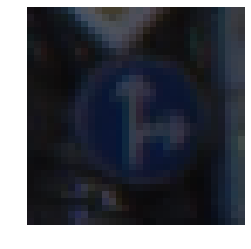

In [11]:
import cv2

plt.imshow(X_train[1002])
plt.axis('off')
print(X_train[1002].shape)
print(y_train[1002])

(32, 32)


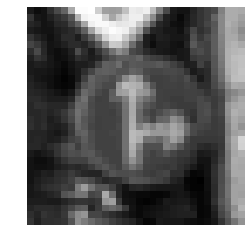

In [12]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1002])
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

(32, 32)


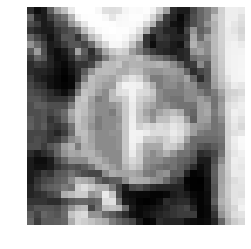

In [13]:
# Histogram Equalization (only accepts gray scale)

def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

In [14]:
# to all images

def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_valid = np.array(list(map(preprocessing, X_valid)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


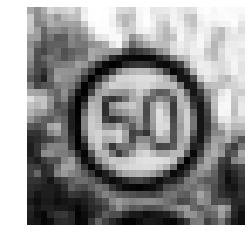

In [15]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap=plt.get_cmap('gray'))
plt.axis('off')
print(X_train.shape)

In [16]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)

In [17]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                               height_shift_range=0.1,
                                zoom_range=0.2,
                              shear_range=0.1,
                              rotation_range=10)

datagen.fit(X_train)

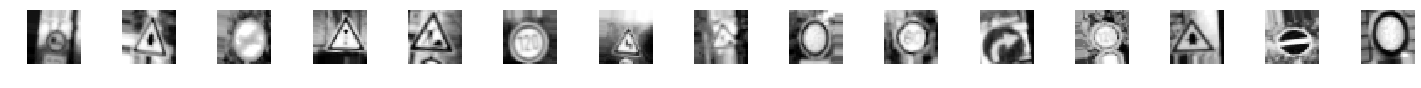

In [18]:
batches = datagen.flow(X_train, y_train,batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32,32), cmap=plt.get_cmap('gray'))
    axs[i].axis('off')

In [19]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [20]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_valid = to_categorical(y_valid, 43)

In [21]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [22]:
model = modified_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)               0         
__________

In [23]:
# To free the Memory to utilize GPU (ONLY FOR ME) you can skip this code block

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [24]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_valid,y_valid), shuffle=1)

Epoch 1/10
2000/2000 [==============================] - 152s 76ms/step - loss: 0.9043 - acc: 0.7341 - val_loss: 0.0880 - val_acc: 0.9728
Epoch 2/10
2000/2000 [==============================] - 133s 67ms/step - loss: 0.2195 - acc: 0.9318 - val_loss: 0.0570 - val_acc: 0.9805
Epoch 3/10
2000/2000 [==============================] - 133s 67ms/step - loss: 0.1480 - acc: 0.9543 - val_loss: 0.0350 - val_acc: 0.9893
Epoch 4/10
2000/2000 [==============================] - 133s 67ms/step - loss: 0.1174 - acc: 0.9638 - val_loss: 0.0516 - val_acc: 0.9834
Epoch 5/10
2000/2000 [==============================] - 134s 67ms/step - loss: 0.0970 - acc: 0.9694 - val_loss: 0.0541 - val_acc: 0.9823
Epoch 6/10
2000/2000 [==============================] - 137s 69ms/step - loss: 0.0856 - acc: 0.9741 - val_loss: 0.0196 - val_acc: 0.9934
Epoch 7/10
2000/2000 [==============================] - 141s 71ms/step - loss: 0.0748 - acc: 0.9777 - val_loss: 0.0290 - val_acc: 0.9918
Epoch 8/10
2000/2000 [===================

Text(0.5, 0, 'epoch')

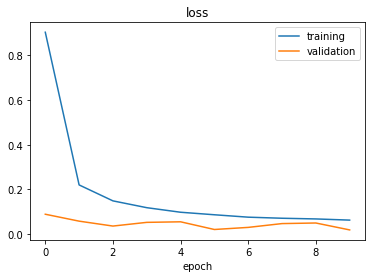

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

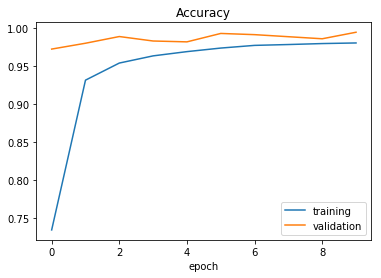

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [27]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

<class 'list'>
Test Score: 0.09857681828569613
Test Accuracy: 0.9742676168326244


## Testing

Now we can randomly take pictures from the web & test our Model.

<Response [200]>


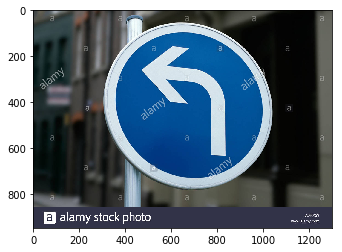

In [28]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
response = requests.get(url,stream=True)
print(response)
img = Image.open(response.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(946, 1300, 3)
(32, 32, 3)
(32, 32)


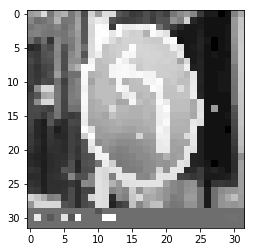

In [29]:
import cv2

img = np.asarray(img)
print(img.shape)

img =cv2.resize(img, (32,32))
print(img.shape)
img = preprocessing(img)

plt.imshow(img, cmap=plt.get_cmap('gray') )
print(img.shape)

In [30]:
img = img.reshape(1, 32,32,1)

In [31]:
prediction = model.predict_classes(img)
print("predicted sign:", str(prediction))

predicted sign: [34]
